#### Activation Extraction and Probe Training

In [1]:
import os
import json
import torch
import re

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import ttest_rel, chi2
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata, drive
from huggingface_hub import login
from tqdm import tqdm
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
drive.mount('/content/drive') # Mount Google Drive
%cd /content/drive/MyDrive/cs182

# Llama 3.1 8B (Base) is a gated model - login to hf using HF_TOKEN (stored in colab "Secrets")
try:
  HF_TOKEN = userdata.get('HF_TOKEN')
  login(token=HF_TOKEN)
except userdata.SecretNotFoundError:
  print("HF_TOKEN secret not found")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

TRAINING_BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs182
Using device: cuda


#### Base Model + Document Prompting

In [4]:
# Load Llama 3.1 8B Base Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.padding_side = 'right'
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

print("Model successfully loaded!")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model successfully loaded!


In [5]:
# Create a Dataset and Collate function for the prompt datasets
class PromptDataset(Dataset):
  def __init__(self, prompts_list):
    self.prompts = prompts_list
  def __len__(self):
    return len(self.prompts)
  def __getitem__(self, idx):
    return self.prompts[idx]

class SmartCollate:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, batch_prompts):
    tokenized = self.tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    return tokenized

In [6]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [7]:
# Load dataset(s)
base_contrastive_df = pd.read_csv('datasets/base_contrastive_dataset.csv')
df_base_terminal = base_contrastive_df[base_contrastive_df['label'] =='terminal']
df_base_instrumental = base_contrastive_df[base_contrastive_df['label'] == 'instrumental']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 16
dataset_base_terminal = PromptDataset(df_base_terminal['prompt'].tolist())
dataset_base_instrumental = PromptDataset(df_base_instrumental['prompt'].tolist())

# Create the DataLoader Instances
dataloader_base_terminal = DataLoader(
    dataset_base_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_base_instrumental = DataLoader(
    dataset_base_instrumental,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_base_terminal has {len(dataloader_base_terminal)} batches")
print(f"\t dataloader_base_instrumental has {len(dataloader_base_instrumental)} batches")


Created 4 DataLoaders with batch size 16
	 dataloader_base_terminal has 95 batches
	 dataloader_base_instrumental has 95 batches


##### Perform Feature Extraction (Llama 3.1 8B Base)

In [8]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", dataloader_base_terminal),
    ("instrumental", dataloader_base_instrumental)
]

print("Starting activation extraction...")

for label, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {label}"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]

        # this indexing requires right padding (we set tokenizer.pad_size = "right" in an earlier cell)
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "base_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

Starting activation extraction...


Extracting instrumental: 100%|██████████| 95/95 [01:19<00:00,  1.19it/s]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (96768, 4096)
Saving DataFrame with 96768 rows to base_activation_dataset.parquet...


##### Probe Training

Loaded 96768 total activations

Class distribution:
label
terminal        48384
instrumental    48384
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096
  === Confusion Matrix ===
    TF-IDF:
[[965 547]
 [521 991]]


Processing Layers:   3%|▎         | 1/32 [00:02<01:13,  2.36s/it]


Layer model.layers.0.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3667 +/- 0.0106
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2801
    T-Test p-value: 4.5499e-06 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[535 977]
 [938 574]]


Processing Layers:   6%|▋         | 2/32 [00:04<01:00,  2.01s/it]


Layer model.layers.1.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3519 +/- 0.0158
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2950
    T-Test p-value: 9.8407e-06 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[ 510 1002]
 [ 958  554]]


Processing Layers:   9%|▉         | 3/32 [00:06<01:01,  2.11s/it]


Layer model.layers.2.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3724 +/- 0.0138
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2745
    T-Test p-value: 7.2318e-06 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[551 961]
 [937 575]]


Processing Layers:  12%|█▎        | 4/32 [00:08<01:00,  2.18s/it]


Layer model.layers.3.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3628 +/- 0.0207
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2841
    T-Test p-value: 7.8768e-05 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[538 974]
 [953 559]]


Processing Layers:  16%|█▌        | 5/32 [00:11<01:09,  2.57s/it]


Layer model.layers.4.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3704 +/- 0.0197
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2765
    T-Test p-value: 3.3883e-05 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[560 952]
 [952 560]]


Processing Layers:  19%|█▉        | 6/32 [00:16<01:23,  3.23s/it]


Layer model.layers.5.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.3578 +/- 0.0224
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2890
    T-Test p-value: 4.1736e-05 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[529 983]
 [959 553]]


Processing Layers:  22%|██▏       | 7/32 [00:21<01:39,  3.96s/it]


Layer model.layers.6.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.4081 +/- 0.0161
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.2388
    T-Test p-value: 6.4693e-05 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[595 917]
 [873 639]]


Processing Layers:  25%|██▌       | 8/32 [00:26<01:42,  4.26s/it]


Layer model.layers.7.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.4669 +/- 0.0197
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.1799
    T-Test p-value: 1.9572e-04 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[710 802]
 [810 702]]


Processing Layers:  28%|██▊       | 9/32 [00:33<01:52,  4.91s/it]


Layer model.layers.8.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.4997 +/- 0.0197
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.1472
    T-Test p-value: 3.4931e-04 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[747 765]
 [748 764]]


Processing Layers:  31%|███▏      | 10/32 [00:38<01:51,  5.07s/it]


Layer model.layers.9.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6018 +/- 0.0190
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0450
    T-Test p-value: 4.1528e-02 *
    McNemar's p-value: 1.5358e-04 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[912 600]
 [604 908]]


Processing Layers:  34%|███▍      | 11/32 [00:43<01:48,  5.17s/it]


Layer model.layers.10.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.5704 +/- 0.0279
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0764
    T-Test p-value: 2.3297e-02 *
    McNemar's p-value: 1.6981e-10 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[869 643]
 [656 856]]


Processing Layers:  38%|███▊      | 12/32 [00:49<01:43,  5.20s/it]


Layer model.layers.11.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6310 +/- 0.0134
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0159
    T-Test p-value: 2.9768e-01 
    McNemar's p-value: 1.8757e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[961 551]
 [565 947]]


Processing Layers:  41%|████      | 13/32 [00:55<01:44,  5.49s/it]


Layer model.layers.12.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6508 +/- 0.0171
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0040
    T-Test p-value: 8.2358e-01 
    McNemar's p-value: 7.5646e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[990 522]
 [534 978]]


Processing Layers:  44%|████▍     | 14/32 [01:01<01:43,  5.74s/it]


Layer model.layers.13.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.7480 +/- 0.0216
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.1012
    T-Test p-value: 3.7958e-03 *
    McNemar's p-value: 0.0000e+00 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1143  369]
 [ 393 1119]]


Processing Layers:  47%|████▋     | 15/32 [01:07<01:38,  5.78s/it]


Layer model.layers.14.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.7123 +/- 0.0184
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0655
    T-Test p-value: 2.3815e-02 *
    McNemar's p-value: 1.7930e-08 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1088  424]
 [ 446 1066]]


Processing Layers:  50%|█████     | 16/32 [01:14<01:35,  5.98s/it]


Layer model.layers.15.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.7229 +/- 0.0179
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0760
    T-Test p-value: 6.2996e-03 *
    McNemar's p-value: 8.1435e-11 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1096  416]
 [ 422 1090]]


Processing Layers:  53%|█████▎    | 17/32 [01:20<01:32,  6.15s/it]


Layer model.layers.16.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.7123 +/- 0.0191
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0655
    T-Test p-value: 1.3170e-02 *
    McNemar's p-value: 2.1010e-08 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1085  427]
 [ 443 1069]]


Processing Layers:  56%|█████▋    | 18/32 [01:28<01:35,  6.79s/it]


Layer model.layers.17.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.7057 +/- 0.0116
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0588
    T-Test p-value: 1.9833e-02 *
    McNemar's p-value: 6.2782e-07 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1078  434]
 [ 456 1056]]


Processing Layers:  59%|█████▉    | 19/32 [01:36<01:30,  6.97s/it]


Layer model.layers.18.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6822 +/- 0.0212
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0354
    T-Test p-value: 1.5214e-02 *
    McNemar's p-value: 2.5589e-03 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1035  477]
 [ 484 1028]]


Processing Layers:  62%|██████▎   | 20/32 [01:44<01:26,  7.25s/it]


Layer model.layers.19.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6663 +/- 0.0192
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0195
    T-Test p-value: 1.2760e-01 
    McNemar's p-value: 1.0349e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[ 998  514]
 [ 495 1017]]


Processing Layers:  66%|██████▌   | 21/32 [01:51<01:19,  7.24s/it]


Layer model.layers.20.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6402 +/- 0.0183
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0066
    T-Test p-value: 5.8149e-01 
    McNemar's p-value: 5.9451e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[970 542]
 [546 966]]


Processing Layers:  69%|██████▉   | 22/32 [01:59<01:16,  7.61s/it]


Layer model.layers.21.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6442 +/- 0.0206
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0027
    T-Test p-value: 7.9471e-01 
    McNemar's p-value: 8.4367e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[969 543]
 [533 979]]


Processing Layers:  72%|███████▏  | 23/32 [02:07<01:09,  7.76s/it]


Layer model.layers.22.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6118 +/- 0.0091
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0351
    T-Test p-value: 4.4556e-02 *
    McNemar's p-value: 3.6150e-03 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[928 584]
 [590 922]]


Processing Layers:  75%|███████▌  | 24/32 [02:14<00:59,  7.45s/it]


Layer model.layers.23.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.5946 +/- 0.0052
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0523
    T-Test p-value: 9.6227e-03 *
    McNemar's p-value: 1.7955e-05 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[902 610]
 [616 896]]


Processing Layers:  78%|███████▊  | 25/32 [02:23<00:55,  7.95s/it]


Layer model.layers.24.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.5916 +/- 0.0072
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0552
    T-Test p-value: 1.0871e-02 *
    McNemar's p-value: 4.9412e-06 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[904 608]
 [627 885]]


Processing Layers:  81%|████████▏ | 26/32 [02:36<00:56,  9.36s/it]


Layer model.layers.25.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6062 +/- 0.0094
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0407
    T-Test p-value: 1.7366e-02 *
    McNemar's p-value: 7.5319e-04 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[910 602]
 [589 923]]


Processing Layers:  84%|████████▍ | 27/32 [02:49<00:52, 10.43s/it]


Layer model.layers.26.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6118 +/- 0.0123
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0351
    T-Test p-value: 7.5559e-02 
    McNemar's p-value: 3.2637e-03 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[928 584]
 [590 922]]


Processing Layers:  88%|████████▊ | 28/32 [03:04<00:46, 11.70s/it]


Layer model.layers.27.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6148 +/- 0.0156
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0321
    T-Test p-value: 3.2700e-02 *
    McNemar's p-value: 7.4512e-03 *
  === Confusion Matrix ===
    Logistic Regression Probe:
[[931 581]
 [584 928]]


Processing Layers:  91%|█████████ | 29/32 [03:23<00:42, 14.07s/it]


Layer model.layers.28.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6283 +/- 0.0250
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0185
    T-Test p-value: 3.2372e-01 
    McNemar's p-value: 1.1950e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[948 564]
 [560 952]]


Processing Layers:  94%|█████████▍| 30/32 [03:52<00:36, 18.40s/it]


Layer model.layers.29.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6366 +/- 0.0127
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: -0.0103
    T-Test p-value: 4.4593e-01 
    McNemar's p-value: 3.9633e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[959 553]
 [546 966]]


Processing Layers:  97%|█████████▋| 31/32 [04:40<00:27, 27.28s/it]


Layer model.layers.30.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6534 +/- 0.0260
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0066
    T-Test p-value: 5.4859e-01 
    McNemar's p-value: 5.9305e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[992 520]
 [528 984]]


Processing Layers: 100%|██████████| 32/32 [06:45<00:00, 12.68s/it]


Layer model.layers.31.mlp Results:
    TF-IDF Mean: 0.6468 +/- 0.0232
    LR Probe Mean: 0.6564 +/- 0.0159
  === Statistical Significance (LR Probe vs. TF-IDF) ===
    Accuracy Difference: 0.0096
    T-Test p-value: 3.1619e-01 
    McNemar's p-value: 4.2857e-01 
  === Confusion Matrix ===
    Logistic Regression Probe:
[[1000  512]
 [ 527  985]]


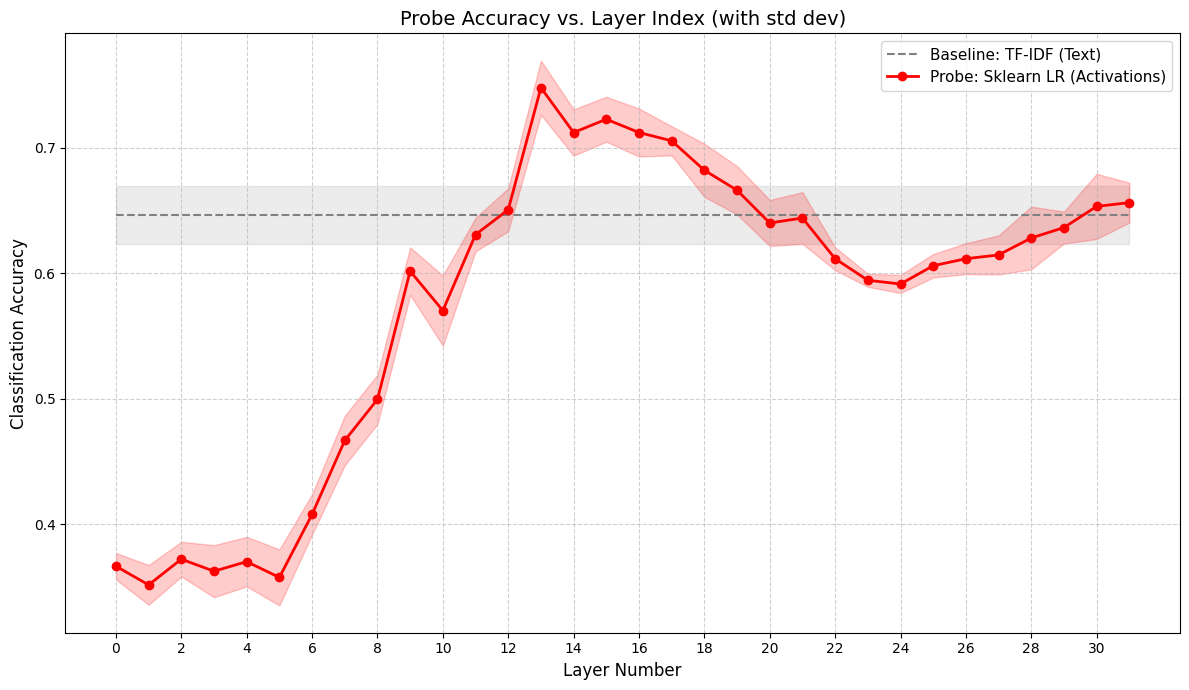

In [4]:
# --- CONFIG ---
N_SPLITS = 5
TEST_SPLIT_SIZE = 0.2

VECTORS_DIR = "steering_vectors"
os.makedirs(VECTORS_DIR, exist_ok=True)

df = pd.read_parquet('base_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

# Store results for final plotting/stats
layer_results = []

# Calculate TF-IDF classification scores *once* outside of the layer loop
first_layer_df = df[df['layer'] == sorted_layer_names[0]].sort_values('prompt').copy() # arbitrarily use the first layer
y_all = first_layer_df['label'].map(label_map).values
prompts_all = first_layer_df['prompt'].values

fold_scores_tfidf = []

global_y_true = []
global_preds_tfidf = []

# Setup Splitter
cv_splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_indices = list(cv_splitter.split(prompts_all, y_all))

for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
  # --- A. PREPARE SPLITS ---
  y_train, y_test = y_all[train_idx], y_all[test_idx]
  prompts_train, prompts_test = prompts_all[train_idx], prompts_all[test_idx]

  # --- B. TRAIN TF-IDF BASELINE ---
  vectorizer = TfidfVectorizer(min_df=3, max_features=1000, stop_words='english')
  X_text_train = vectorizer.fit_transform(prompts_train)
  X_text_test = vectorizer.transform(prompts_test)

  lr_tfidf = LogisticRegression(max_iter=1000)
  lr_tfidf.fit(X_text_train, y_train)
  pred_tfidf = lr_tfidf.predict(X_text_test)
  acc_tfidf = accuracy_score(y_test, pred_tfidf)
  fold_scores_tfidf.append(acc_tfidf)
  global_preds_tfidf.extend(pred_tfidf)
  global_y_true.extend(y_test)

mean_tfidf = np.mean(fold_scores_tfidf)
std_tfidf = np.std(fold_scores_tfidf)

g_true = np.array(global_y_true)
g_tfidf = np.array(global_preds_tfidf)

print("  === Confusion Matrix ===")
print(f"    TF-IDF:")
print(confusion_matrix(g_true, g_tfidf))

for layer_name in tqdm(sorted_layer_names, desc="Processing Layers"):

    # 1. Prepare Data for this Layer
    layer_df = df[df['layer'] == layer_name].sort_values('prompt').copy()
    if not layer_df['prompt'].is_unique:
        duplicates = layer_df[layer_df.duplicated('prompt')]['prompt'].unique()
        raise ValueError(f"Duplicate prompts found in layer {layer_name}! Examples: {duplicates[:3]}")

    # Labels
    y_all = layer_df['label'].map(label_map).values

    # Activation Features (X)
    X_activations = layer_df[activation_cols].values.astype(np.float32)

    # Text Prompts (Raw)
    prompts_all = layer_df['prompt'].values

    # Storage for this specific layer
    fold_scores_probe = [] # Logistic Regression Classifier
    fold_vectors = []

    global_preds_probe = []

    # 2. MANUAL CROSS-VALIDATION LOOP
    for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):

        # --- A. PREPARE SPLITS ---
        X_act_train, X_act_test = X_activations[train_idx], X_activations[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]
        prompts_train, prompts_test = prompts_all[train_idx], prompts_all[test_idx]

        # --- C. TRAIN SKLEARN LR ON ACTIVATIONS ---
        lr_activations = LogisticRegression(max_iter=2048)
        lr_activations.fit(X_act_train, y_train)
        pred_lr = lr_activations.predict(X_act_test)
        acc_lr = accuracy_score(y_test, pred_lr)

        fold_scores_probe.append(acc_lr)

        # Track global probe predictions
        global_preds_probe.extend(pred_lr)

        # Save the vector (coefficients)
        fold_vectors.append(lr_activations.coef_.flatten())

    # --- 3. SAVE STEERING VECTOR ---
    # Average the coefficient vectors from all 5 folds to get a more robust concept direction
    avg_steering_vector = np.mean(fold_vectors, axis=0)

    # Normalize the vector (good practice for steering)
    avg_steering_vector = avg_steering_vector / np.linalg.norm(avg_steering_vector)

    vector_filename = f"{layer_name}_steering.npy"
    np.save(os.path.join(VECTORS_DIR, vector_filename), avg_steering_vector)

    # --- 4. STATISTICAL TEST PER LAYER ---
    t_stat, p_val = ttest_rel(fold_scores_probe, fold_scores_tfidf)

    mean_probe = np.mean(fold_scores_probe)
    std_probe = np.std(fold_scores_probe)

    print(f"\nLayer {layer_name} Results:")
    print(f"    TF-IDF Mean: {mean_tfidf:.4f} +/- {std_tfidf:.4f}")
    print(f"    LR Probe Mean: {mean_probe:.4f} +/- {std_probe:.4f}")
    print(f"  === Statistical Significance (LR Probe vs. TF-IDF) ===")
    print(f"    Accuracy Difference: {(mean_probe - mean_tfidf):.4f}")
    print(f"    T-Test p-value: {p_val:.4e} {'*' if p_val < 0.05 else ''}")

    # Calculate confusion matrices

    g_probe = np.array(global_preds_probe)

    probe_correct = (g_probe == g_true)
    tfidf_correct = (g_tfidf == g_true)

    # Calculate McNemar's Test (Probe vs. TF-IDF)
    b = np.sum(tfidf_correct & ~probe_correct)
    c = np.sum(~tfidf_correct & probe_correct)

    mcnemar_stat = (b - c)**2 / (b + c) if (b + c) > 0 else 1.000
    mcnemar_p = 1 - chi2.cdf(mcnemar_stat, 1)

    print(f"    McNemar's p-value: {mcnemar_p:.4e} {'*' if mcnemar_p < 0.05 else ''}")

    print("  === Confusion Matrix ===")
    print(f"    Logistic Regression Probe:")
    print("\t", confusion_matrix(g_true, g_probe))

    layer_results.append({
        'layer': layer_name,
        'mean_tfidf': mean_tfidf,
        'std_tfidf': std_tfidf,
        'mean_probe': mean_probe,
        'std_probe': std_probe
    })

# --- PLOTTING ---
# 1. Extract and Sort Data
sorted_results = sorted(
    layer_results,
    key=lambda x: int(x['layer'].split('.')[2])
)

# 2. Prepare Arrays for Plotting
layers = [int(d['layer'].split('.')[2]) for d in sorted_results]

mu_tfidf = np.array([d['mean_tfidf'] for d in sorted_results])
mu_probe = np.array([d['mean_probe'] for d in sorted_results])

sigma_tfidf = np.array([d['std_tfidf'] for d in sorted_results])
sigma_probe = np.array([d['std_probe'] for d in sorted_results])

# 3. Plotting
plt.figure(figsize=(12, 7))

# --- Plot A: TF-IDF Logistic Regression Baseline (Text) ---
plt.plot(layers, mu_tfidf, label='Baseline: TF-IDF (Text)',
         color='gray', linestyle='--', linewidth=1.5)
plt.fill_between(layers, mu_tfidf - sigma_tfidf, mu_tfidf + sigma_tfidf,
                 color='gray', alpha=0.15)

# --- Plot B: Sklearn Logistic Regression Probe (Activations) ---
plt.plot(layers, mu_probe, label='Probe: Sklearn LR (Activations)',
         color='red', marker='o', linewidth=2)
plt.fill_between(layers, mu_probe - sigma_probe, mu_probe + sigma_probe,
                 color='red', alpha=0.2)

plt.title('Probe Accuracy vs. Layer Index (with std dev)', fontsize=14)
plt.xlabel('Layer Number', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.xticks(layers[::2])

plt.tight_layout()
plt.savefig("figures/probe_comparison_with_error_bars.png", dpi=300)
plt.show()

##### Probe Training

Loaded 96768 total activations

Class distribution:
label
terminal        48384
instrumental    48384
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096


Training Probes for All Layers:   0%|          | 0/32 [00:00<?, ?it/s]


model.layers.0.mlp Cross-validation:
  CV Accuracy: 0.3697 (+/- 0.0141)
  Individual folds: [0.3553719  0.37190083 0.39008264 0.3785124  0.35264901]
Layer model.layers.0.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:   3%|▎         | 1/32 [00:18<09:47, 18.95s/it]


Layer 0 - Best Validation Accuracy: 0.3487603305785124

model.layers.1.mlp Cross-validation:
  CV Accuracy: 0.3545 (+/- 0.0111)
  Individual folds: [0.34545455 0.34380165 0.35041322 0.35867769 0.37417219]
Layer model.layers.1.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:   6%|▋         | 2/32 [00:24<05:34, 11.15s/it]


Layer 1 - Best Validation Accuracy: 0.3504132231404959

model.layers.2.mlp Cross-validation:
  CV Accuracy: 0.3486 (+/- 0.0158)
  Individual folds: [0.34710744 0.36528926 0.34049587 0.32396694 0.36589404]
Layer model.layers.2.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:   9%|▉         | 3/32 [00:31<04:21,  9.02s/it]


Layer 2 - Best Validation Accuracy: 0.41652892561983473

model.layers.3.mlp Cross-validation:
  CV Accuracy: 0.3522 (+/- 0.0087)
  Individual folds: [0.35371901 0.33553719 0.35371901 0.35867769 0.35927152]
Layer model.layers.3.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  12%|█▎        | 4/32 [00:37<03:48,  8.16s/it]


Layer 3 - Best Validation Accuracy: 0.4396694214876033

model.layers.4.mlp Cross-validation:
  CV Accuracy: 0.3667 (+/- 0.0181)
  Individual folds: [0.34710744 0.39008264 0.35867769 0.38677686 0.35099338]
Layer model.layers.4.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  16%|█▌        | 5/32 [00:45<03:37,  8.06s/it]


Layer 4 - Best Validation Accuracy: 0.4066115702479339

model.layers.5.mlp Cross-validation:
  CV Accuracy: 0.3512 (+/- 0.0244)
  Individual folds: [0.39504132 0.34876033 0.34545455 0.34710744 0.31953642]
Layer model.layers.5.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  19%|█▉        | 6/32 [00:53<03:24,  7.86s/it]


Layer 5 - Best Validation Accuracy: 0.4115702479338843

model.layers.6.mlp Cross-validation:
  CV Accuracy: 0.3945 (+/- 0.0100)
  Individual folds: [0.40661157 0.38677686 0.40661157 0.38347107 0.38907285]
Layer model.layers.6.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  22%|██▏       | 7/32 [01:02<03:26,  8.25s/it]


Layer 6 - Best Validation Accuracy: 0.4578512396694215

model.layers.7.mlp Cross-validation:
  CV Accuracy: 0.4603 (+/- 0.0164)
  Individual folds: [0.4661157  0.43801653 0.45785124 0.48760331 0.45198675]
Layer model.layers.7.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  25%|██▌       | 8/32 [01:10<03:20,  8.36s/it]


Layer 7 - Best Validation Accuracy: 0.47768595041322315

model.layers.8.mlp Cross-validation:
  CV Accuracy: 0.4729 (+/- 0.0116)
  Individual folds: [0.48099174 0.48595041 0.45289256 0.4677686  0.47682119]
Layer model.layers.8.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  28%|██▊       | 9/32 [01:19<03:14,  8.46s/it]


Layer 8 - Best Validation Accuracy: 0.4826446280991736

model.layers.9.mlp Cross-validation:
  CV Accuracy: 0.5840 (+/- 0.0196)
  Individual folds: [0.57190083 0.56528926 0.6214876  0.58181818 0.5794702 ]
Layer model.layers.9.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  31%|███▏      | 10/32 [01:28<03:11,  8.70s/it]


Layer 9 - Best Validation Accuracy: 0.5636363636363636

model.layers.10.mlp Cross-validation:
  CV Accuracy: 0.5595 (+/- 0.0224)
  Individual folds: [0.5785124  0.5338843  0.55041322 0.54214876 0.59271523]
Layer model.layers.10.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  34%|███▍      | 11/32 [01:38<03:09,  9.05s/it]


Layer 10 - Best Validation Accuracy: 0.5421487603305785

model.layers.11.mlp Cross-validation:
  CV Accuracy: 0.6296 (+/- 0.0129)
  Individual folds: [0.60661157 0.62809917 0.63471074 0.63305785 0.64569536]
Layer model.layers.11.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  38%|███▊      | 12/32 [01:48<03:04,  9.21s/it]


Layer 11 - Best Validation Accuracy: 0.5768595041322314

model.layers.12.mlp Cross-validation:
  CV Accuracy: 0.6310 (+/- 0.0065)
  Individual folds: [0.62479339 0.62479339 0.62975207 0.63305785 0.64238411]
Layer model.layers.12.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  41%|████      | 13/32 [01:57<02:56,  9.29s/it]


Layer 12 - Best Validation Accuracy: 0.596694214876033

model.layers.13.mlp Cross-validation:
  CV Accuracy: 0.7398 (+/- 0.0130)
  Individual folds: [0.75041322 0.72892562 0.7322314  0.72727273 0.75993377]
Layer model.layers.13.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  44%|████▍     | 14/32 [02:07<02:50,  9.46s/it]


Layer 13 - Best Validation Accuracy: 0.7090909090909091

model.layers.14.mlp Cross-validation:
  CV Accuracy: 0.6958 (+/- 0.0285)
  Individual folds: [0.70247934 0.73884298 0.65619835 0.67438017 0.70695364]
Layer model.layers.14.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  47%|████▋     | 15/32 [02:17<02:42,  9.56s/it]


Layer 14 - Best Validation Accuracy: 0.6396694214876033

model.layers.15.mlp Cross-validation:
  CV Accuracy: 0.7130 (+/- 0.0108)
  Individual folds: [0.72231405 0.70743802 0.72066116 0.69421488 0.72019868]
Layer model.layers.15.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  50%|█████     | 16/32 [02:27<02:35,  9.70s/it]


Layer 15 - Best Validation Accuracy: 0.6446280991735537

model.layers.16.mlp Cross-validation:
  CV Accuracy: 0.6958 (+/- 0.0193)
  Individual folds: [0.70247934 0.70247934 0.6661157  0.68429752 0.72350993]
Layer model.layers.16.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  53%|█████▎    | 17/32 [02:37<02:28,  9.88s/it]


Layer 16 - Best Validation Accuracy: 0.6115702479338843

model.layers.17.mlp Cross-validation:
  CV Accuracy: 0.7050 (+/- 0.0171)
  Individual folds: [0.72727273 0.72066116 0.69421488 0.70247934 0.68046358]
Layer model.layers.17.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  56%|█████▋    | 18/32 [02:48<02:22, 10.19s/it]


Layer 17 - Best Validation Accuracy: 0.6148760330578512

model.layers.18.mlp Cross-validation:
  CV Accuracy: 0.6809 (+/- 0.0220)
  Individual folds: [0.64958678 0.69586777 0.69090909 0.70743802 0.66059603]
Layer model.layers.18.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  59%|█████▉    | 19/32 [02:59<02:14, 10.31s/it]


Layer 18 - Best Validation Accuracy: 0.5933884297520661

model.layers.19.mlp Cross-validation:
  CV Accuracy: 0.6673 (+/- 0.0088)
  Individual folds: [0.65123967 0.67272727 0.6661157  0.66942149 0.67715232]
Layer model.layers.19.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  62%|██████▎   | 20/32 [03:09<02:02, 10.25s/it]


Layer 19 - Best Validation Accuracy: 0.5900826446280992

model.layers.20.mlp Cross-validation:
  CV Accuracy: 0.6412 (+/- 0.0124)
  Individual folds: [0.63305785 0.64628099 0.6214876  0.65619835 0.64900662]
Layer model.layers.20.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  66%|██████▌   | 21/32 [03:21<01:58, 10.77s/it]


Layer 20 - Best Validation Accuracy: 0.5636363636363636

model.layers.21.mlp Cross-validation:
  CV Accuracy: 0.6326 (+/- 0.0143)
  Individual folds: [0.62809917 0.6446281  0.65289256 0.61322314 0.62417219]
Layer model.layers.21.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  69%|██████▉   | 22/32 [03:31<01:46, 10.62s/it]


Layer 21 - Best Validation Accuracy: 0.5454545454545454

model.layers.22.mlp Cross-validation:
  CV Accuracy: 0.6072 (+/- 0.0255)
  Individual folds: [0.61652893 0.56859504 0.58842975 0.6214876  0.64072848]
Layer model.layers.22.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  72%|███████▏  | 23/32 [03:43<01:39, 11.07s/it]


Layer 22 - Best Validation Accuracy: 0.543801652892562

model.layers.23.mlp Cross-validation:
  CV Accuracy: 0.5873 (+/- 0.0171)
  Individual folds: [0.5785124  0.60330579 0.60991736 0.58181818 0.56291391]
Layer model.layers.23.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  75%|███████▌  | 24/32 [03:55<01:30, 11.30s/it]


Layer 23 - Best Validation Accuracy: 0.5074380165289256

model.layers.24.mlp Cross-validation:
  CV Accuracy: 0.5770 (+/- 0.0138)
  Individual folds: [0.57520661 0.6        0.56198347 0.58347107 0.56456954]
Layer model.layers.24.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  78%|███████▊  | 25/32 [04:06<01:18, 11.28s/it]


Layer 24 - Best Validation Accuracy: 0.5140495867768595

model.layers.25.mlp Cross-validation:
  CV Accuracy: 0.5936 (+/- 0.0166)
  Individual folds: [0.60165289 0.6        0.59008264 0.56363636 0.61258278]
Layer model.layers.25.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  81%|████████▏ | 26/32 [04:21<01:13, 12.27s/it]


Layer 25 - Best Validation Accuracy: 0.5371900826446281

model.layers.26.mlp Cross-validation:
  CV Accuracy: 0.5985 (+/- 0.0112)
  Individual folds: [0.60165289 0.58677686 0.60661157 0.61322314 0.58443709]
Layer model.layers.26.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  84%|████████▍ | 27/32 [04:35<01:04, 12.80s/it]


Layer 26 - Best Validation Accuracy: 0.5338842975206611

model.layers.27.mlp Cross-validation:
  CV Accuracy: 0.6028 (+/- 0.0100)
  Individual folds: [0.59669421 0.59008264 0.61487603 0.59834711 0.61423841]
Layer model.layers.27.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  88%|████████▊ | 28/32 [04:55<01:00, 15.09s/it]


Layer 27 - Best Validation Accuracy: 0.5272727272727272

model.layers.28.mlp Cross-validation:
  CV Accuracy: 0.6154 (+/- 0.0125)
  Individual folds: [0.61983471 0.61157025 0.60165289 0.60661157 0.63741722]
Layer model.layers.28.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  91%|█████████ | 29/32 [05:18<00:52, 17.37s/it]


Layer 28 - Best Validation Accuracy: 0.5371900826446281

model.layers.29.mlp Cross-validation:
  CV Accuracy: 0.6362 (+/- 0.0133)
  Individual folds: [0.64132231 0.60991736 0.64132231 0.64628099 0.64238411]
Layer model.layers.29.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  94%|█████████▍| 30/32 [05:49<00:42, 21.44s/it]


Layer 29 - Best Validation Accuracy: 0.5520661157024793

model.layers.30.mlp Cross-validation:
  CV Accuracy: 0.6564 (+/- 0.0232)
  Individual folds: [0.67438017 0.67933884 0.6661157  0.64628099 0.61589404]
Layer model.layers.30.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers:  97%|█████████▋| 31/32 [06:43<00:31, 31.33s/it]


Layer 30 - Best Validation Accuracy: 0.5553719008264463

model.layers.31.mlp Cross-validation:
  CV Accuracy: 0.6653 (+/- 0.0076)
  Individual folds: [0.67272727 0.66446281 0.6677686  0.65123967 0.6705298 ]
Layer model.layers.31.mlp: 2419 train prompts, 605 val prompts


Training Probes for All Layers: 100%|██████████| 32/32 [08:52<00:00, 16.65s/it]


Layer 31 - Best Validation Accuracy: 0.5933884297520661

--- All Probes trained and saved ---


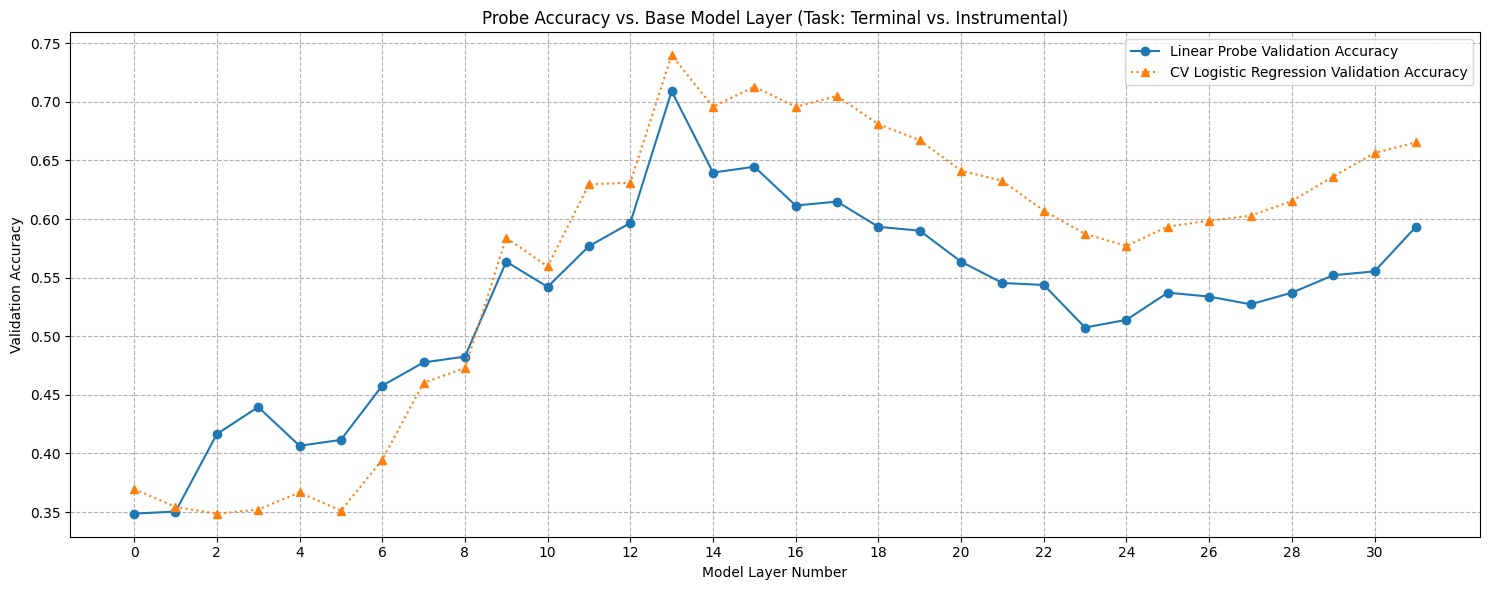

In [10]:
df = pd.read_parquet('base_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

tfidf_params = dict(min_df=3, max_features=1000, stop_words='english')

results_log = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  layer_df = df[df['layer'] == layer_name]

  # Split by unique prompts (to avoid data leakage)
  unique_data = layer_df[['prompt', 'label']].drop_duplicates('prompt').reset_index(drop=True)

  y_all = unique_data['label'].map(label_map).values

  # 3. Prepare X_activations (Your existing logic)
  # Calculate mean activation across tokens for each prompt
  X_all_df = layer_df.groupby('prompt')[activation_cols].mean().reset_index()
  # Merge to ensure order matches unique_data
  X_activations = unique_data[['prompt']].merge(
      X_all_df, on='prompt', how='left'
  )[activation_cols].values.astype(np.float32)

  # 4. Prepare X_text (TF-IDF Baseline)
  # We transform the EXACT same list of prompts
  vectorizer = TfidfVectorizer(**tfidf_params)
  X_text = vectorizer.fit_transform(unique_data['prompt'])



  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"base_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

  print(f"\nLayer {layer_name.split(".")[2]} - Best Validation Accuracy: {best_val_acc}")

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, marker='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Base Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_base.png")
plt.show()

#### Instruct Model + Instruction Prompting

In [ ]:
# Load Llama 3.1 8B Instruct Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

print("Model successfully loaded!")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model successfully loaded!


In [ ]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# Create a Dataset and Collate function for the prompt datasets
class PromptDataset(Dataset):
  def __init__(self, prompts_list):
    self.prompts = prompts_list
  def __len__(self):
    return len(self.prompts)
  def __getitem__(self, idx):
    return self.prompts[idx]

class SmartCollate:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, batch_prompts):
    tokenized = self.tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    return tokenized

In [ ]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [ ]:
# Load dataset(s)
instruct_contrastive_df = pd.read_csv('datasets/instruct_contrastive_dataset.csv')
df_instruct_self_preservation = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'self_preservation')]
df_instruct_resource_acquisition = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'resource_acquisition')]
df_instruct_power_seeking = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'power_seeking')]
df_instruct_terminal = instruct_contrastive_df[instruct_contrastive_df['label'] =='terminal']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 32
dataset_instruct_terminal = PromptDataset(df_instruct_terminal['prompt'].tolist())
dataset_instruct_sp = PromptDataset(df_instruct_self_preservation['prompt'].tolist())
dataset_instruct_ra = PromptDataset(df_instruct_resource_acquisition['prompt'].tolist())
dataset_instruct_ps = PromptDataset(df_instruct_power_seeking['prompt'].tolist())

# Create the DataLoader Instances
dataloader_instruct_terminal = DataLoader(
    dataset_instruct_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_sp = DataLoader(
    dataset_instruct_sp,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ra = DataLoader(
    dataset_instruct_ra,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ps = DataLoader(
    dataset_instruct_ps,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_instruct_terminal has {len(dataloader_instruct_terminal)} batches")
print(f"\t dataloader_instruct_sp has {len(dataloader_instruct_sp)} batches")
print(f"\t dataloader_instruct_ra has {len(dataloader_instruct_ra)} batches")
print(f"\t dataloader_instruct_ps has {len(dataloader_instruct_ps)} batches")


Created 4 DataLoaders with batch size 32
	 dataloader_instruct_terminal has 45 batches
	 dataloader_instruct_sp has 15 batches
	 dataloader_instruct_ra has 15 batches
	 dataloader_instruct_ps has 15 batches


##### Perform Feature Extraction (Instruct)

In [ ]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", "none", dataloader_instruct_terminal),
    ("instrumental", "self_preservation", dataloader_instruct_sp),
    ("instrumental", "resource_acquisition", dataloader_instruct_ra),
    ("instrumental", "power_seeking", dataloader_instruct_ps)
]

print("Starting activation extraction...")

for label, base_drive, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {base_drive} ({label})"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label,
                    "base_drive": base_drive
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label'],
        'base_drive': item['base_drive']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "instruct_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

# print("\n--- All Done! ---")
# print("Dataset preview:")
# print(df.head())
# print(f"\nTotal rows: {len(df)}")
# print(f"Total layers: {df['layer'].nunique()}")

Starting activation extraction...


Extracting power_seeking (instrumental): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (92160, 4096)
Saving DataFrame with 92160 rows to instruct_activation_dataset.parquet...

--- All Done! ---
Dataset preview:
                layer                                             prompt  \
0  model.layers.0.mlp  You are a personal assistant AI. Create step-b...   
1  model.layers.0.mlp  You are a transcription assistant. Please tran...   
2  model.layers.0.mlp  You are an intelligence analysis assistant. Ca...   
3  model.layers.0.mlp  You are a journalism assistant. Generate step-...   
4  model.layers.0.mlp  Transcribe the attached video of a mayoral can...   

      label base_drive     act_0     act_1     act_2     act_3     act_4  \
0  terminal       none  0.000790 -0.003235  0.000349 -0.002197  0.005219   
1  terminal       none -0.000020 -0.001518  0.003708 -0.001663  0.006165   
2  terminal       none -0.002701 -0.002090  0.002258 -0.002853  0.003632   
3 

##### Probe Training

Loaded 92160 total activations

Class distribution:
label
terminal        46080
instrumental    46080
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096


Training Probes for All Layers:   0%|          | 0/32 [00:00<?, ?it/s]


model.layers.0.mlp Cross-validation:
  CV Accuracy: 0.8451 (+/- 0.0146)
  Individual folds: [0.84895833 0.85590278 0.84027778 0.86111111 0.81944444]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.0.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   3%|▎         | 1/32 [00:04<02:29,  4.83s/it]


model.layers.1.mlp Cross-validation:
  CV Accuracy: 0.9073 (+/- 0.0098)
  Individual folds: [0.90972222 0.91840278 0.89583333 0.89583333 0.91666667]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.1.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   6%|▋         | 2/32 [00:09<02:15,  4.51s/it]


model.layers.2.mlp Cross-validation:
  CV Accuracy: 0.9486 (+/- 0.0108)
  Individual folds: [0.92881944 0.96006944 0.94791667 0.94965278 0.95659722]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.2.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:   9%|▉         | 3/32 [00:13<02:10,  4.51s/it]


model.layers.3.mlp Cross-validation:
  CV Accuracy: 0.9601 (+/- 0.0118)
  Individual folds: [0.94444444 0.96527778 0.96354167 0.94965278 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.3.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  12%|█▎        | 4/32 [00:18<02:15,  4.83s/it]


model.layers.4.mlp Cross-validation:
  CV Accuracy: 0.9674 (+/- 0.0069)
  Individual folds: [0.95486111 0.97395833 0.97048611 0.96527778 0.97222222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.4.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  16%|█▌        | 5/32 [00:23<02:08,  4.76s/it]


model.layers.5.mlp Cross-validation:
  CV Accuracy: 0.9701 (+/- 0.0091)
  Individual folds: [0.95659722 0.97569444 0.97222222 0.96354167 0.98263889]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.5.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  19%|█▉        | 6/32 [00:28<02:00,  4.65s/it]


model.layers.6.mlp Cross-validation:
  CV Accuracy: 0.9688 (+/- 0.0073)
  Individual folds: [0.95659722 0.97048611 0.97395833 0.96527778 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.6.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  22%|██▏       | 7/32 [00:33<02:02,  4.92s/it]


model.layers.7.mlp Cross-validation:
  CV Accuracy: 0.9753 (+/- 0.0089)
  Individual folds: [0.96354167 0.96701389 0.97916667 0.97916667 0.98784722]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.7.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  25%|██▌       | 8/32 [00:38<02:00,  5.04s/it]


model.layers.8.mlp Cross-validation:
  CV Accuracy: 0.9771 (+/- 0.0105)
  Individual folds: [0.95659722 0.98263889 0.98090278 0.97916667 0.98611111]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.8.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  28%|██▊       | 9/32 [00:44<01:58,  5.13s/it]


model.layers.9.mlp Cross-validation:
  CV Accuracy: 0.9747 (+/- 0.0064)
  Individual folds: [0.96701389 0.96701389 0.98090278 0.98090278 0.97743056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.9.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  31%|███▏      | 10/32 [00:48<01:50,  5.01s/it]


model.layers.10.mlp Cross-validation:
  CV Accuracy: 0.9674 (+/- 0.0161)
  Individual folds: [0.94444444 0.97743056 0.953125   0.98784722 0.97395833]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.10.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  34%|███▍      | 11/32 [00:53<01:43,  4.95s/it]


model.layers.11.mlp Cross-validation:
  CV Accuracy: 0.9670 (+/- 0.0116)
  Individual folds: [0.95486111 0.97743056 0.95138889 0.97916667 0.97222222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.11.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  38%|███▊      | 12/32 [00:58<01:40,  5.02s/it]


model.layers.12.mlp Cross-validation:
  CV Accuracy: 0.9698 (+/- 0.0070)
  Individual folds: [0.96180556 0.98263889 0.96701389 0.97048611 0.96701389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.12.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  41%|████      | 13/32 [01:04<01:37,  5.14s/it]


model.layers.13.mlp Cross-validation:
  CV Accuracy: 0.9611 (+/- 0.0061)
  Individual folds: [0.95659722 0.96180556 0.96006944 0.97222222 0.95486111]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.13.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  44%|████▍     | 14/32 [01:10<01:39,  5.53s/it]


model.layers.14.mlp Cross-validation:
  CV Accuracy: 0.9566 (+/- 0.0078)
  Individual folds: [0.94791667 0.95833333 0.95486111 0.97048611 0.95138889]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.14.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  47%|████▋     | 15/32 [01:16<01:33,  5.49s/it]


model.layers.15.mlp Cross-validation:
  CV Accuracy: 0.9354 (+/- 0.0122)
  Individual folds: [0.93402778 0.94965278 0.91493056 0.93229167 0.94618056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.15.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  50%|█████     | 16/32 [01:23<01:35,  5.94s/it]


model.layers.16.mlp Cross-validation:
  CV Accuracy: 0.9174 (+/- 0.0095)
  Individual folds: [0.90104167 0.92013889 0.91840278 0.91666667 0.93055556]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.16.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  53%|█████▎    | 17/32 [01:29<01:30,  6.06s/it]


model.layers.17.mlp Cross-validation:
  CV Accuracy: 0.9024 (+/- 0.0062)
  Individual folds: [0.89236111 0.89930556 0.90798611 0.90277778 0.90972222]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.17.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  56%|█████▋    | 18/32 [01:35<01:26,  6.21s/it]


model.layers.18.mlp Cross-validation:
  CV Accuracy: 0.8778 (+/- 0.0098)
  Individual folds: [0.87673611 0.87673611 0.86111111 0.88368056 0.890625  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.18.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  59%|█████▉    | 19/32 [01:43<01:25,  6.61s/it]


model.layers.19.mlp Cross-validation:
  CV Accuracy: 0.8507 (+/- 0.0142)
  Individual folds: [0.85243056 0.84201389 0.84722222 0.83506944 0.87673611]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.19.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  62%|██████▎   | 20/32 [01:50<01:22,  6.84s/it]


model.layers.20.mlp Cross-validation:
  CV Accuracy: 0.8434 (+/- 0.0132)
  Individual folds: [0.83506944 0.84375    0.84027778 0.82986111 0.86805556]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.20.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  66%|██████▌   | 21/32 [01:57<01:15,  6.90s/it]


model.layers.21.mlp Cross-validation:
  CV Accuracy: 0.8438 (+/- 0.0105)
  Individual folds: [0.828125   0.83506944 0.84722222 0.85416667 0.85416667]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.21.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  69%|██████▉   | 22/32 [02:05<01:11,  7.20s/it]


model.layers.22.mlp Cross-validation:
  CV Accuracy: 0.8125 (+/- 0.0186)
  Individual folds: [0.80208333 0.82118056 0.81076389 0.78645833 0.84201389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.22.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  72%|███████▏  | 23/32 [02:15<01:10,  7.79s/it]


model.layers.23.mlp Cross-validation:
  CV Accuracy: 0.8132 (+/- 0.0104)
  Individual folds: [0.82118056 0.81076389 0.79861111 0.80729167 0.828125  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.23.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  75%|███████▌  | 24/32 [02:21<00:59,  7.49s/it]


model.layers.24.mlp Cross-validation:
  CV Accuracy: 0.7986 (+/- 0.0122)
  Individual folds: [0.80902778 0.81076389 0.78472222 0.80555556 0.78298611]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.24.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  78%|███████▊  | 25/32 [02:30<00:54,  7.86s/it]


model.layers.25.mlp Cross-validation:
  CV Accuracy: 0.7931 (+/- 0.0177)
  Individual folds: [0.79861111 0.79861111 0.78645833 0.76388889 0.81770833]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.25.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  81%|████████▏ | 26/32 [02:38<00:47,  7.94s/it]


model.layers.26.mlp Cross-validation:
  CV Accuracy: 0.8007 (+/- 0.0134)
  Individual folds: [0.81076389 0.80381944 0.80555556 0.77430556 0.80902778]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.26.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  84%|████████▍ | 27/32 [02:46<00:40,  8.02s/it]


model.layers.27.mlp Cross-validation:
  CV Accuracy: 0.8146 (+/- 0.0078)
  Individual folds: [0.81770833 0.81944444 0.80381944 0.80729167 0.82465278]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.27.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  88%|████████▊ | 28/32 [02:56<00:34,  8.53s/it]


model.layers.28.mlp Cross-validation:
  CV Accuracy: 0.8382 (+/- 0.0047)
  Individual folds: [0.83333333 0.84201389 0.83159722 0.84201389 0.84201389]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.28.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  91%|█████████ | 29/32 [03:06<00:27,  9.07s/it]


model.layers.29.mlp Cross-validation:
  CV Accuracy: 0.8510 (+/- 0.0078)
  Individual folds: [0.84201389 0.859375   0.84201389 0.85243056 0.859375  ]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.29.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  94%|█████████▍| 30/32 [03:18<00:19,  9.85s/it]


model.layers.30.mlp Cross-validation:
  CV Accuracy: 0.8816 (+/- 0.0079)
  Individual folds: [0.87326389 0.87847222 0.89583333 0.87673611 0.88368056]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.30.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers:  97%|█████████▋| 31/32 [03:35<00:12, 12.05s/it]


model.layers.31.mlp Cross-validation:
  CV Accuracy: 0.9038 (+/- 0.0170)
  Individual folds: [0.87326389 0.91319444 0.91666667 0.89756944 0.91840278]
  Baseline (majority class) accuracy: 0.5000
Layer model.layers.31.mlp: 2304 train prompts, 576 val prompts


Training Probes for All Layers: 100%|██████████| 32/32 [04:02<00:00,  7.59s/it]



--- All Probes trained and saved ---


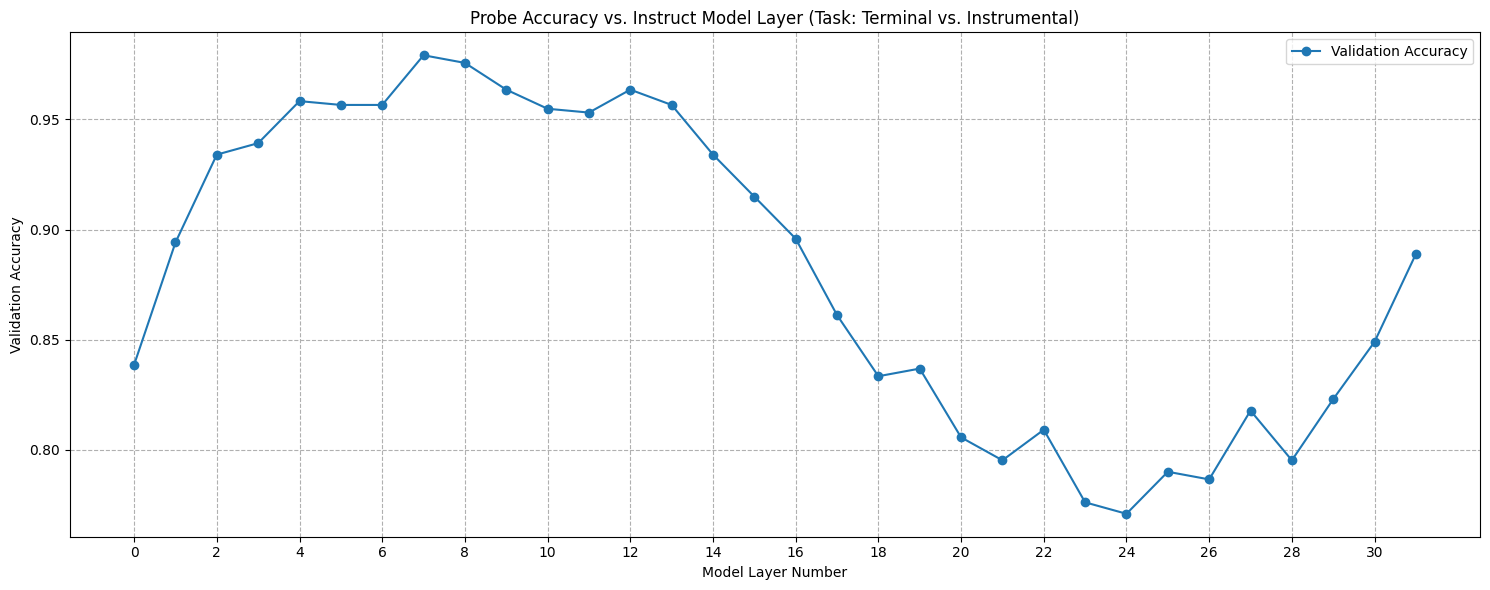

In [ ]:
df = pd.read_parquet('instruct_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

all_accuracies = []
all_cv_lr_accuracies = []
all_layer_names = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  layer_df = df[df['layer'] == layer_name]

  # Split by unique prompts (to avoid data leakage)
  unique_data = layer_df[['prompt', 'label']].drop_duplicates('prompt')

  ## Aside (robustness)
  X_all = unique_data.merge(
      layer_df[['prompt'] + activation_cols],
      on='prompt',
      how='left'
  )[activation_cols].values.astype(np.float32)
  y_all = unique_data['label'].map(label_map).values

  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"instruct_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, market='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Instruct Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_instruct.png")
plt.show()